In [1]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


I had to use the following code to install cartopy on my machine and import the package that was needed. This is what produces the map at the bottom.

In [2]:
conda install -c conda-forge cartopy


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import xarray as xr
import os
import cftime
import numpy as np



path = os.getcwd()
ds = xr.open_dataset(path + "/files/gistemp1200_GHCNv4_ERSSTv5.nc.gz", decode_times=True)
# , decode_times=True, use_cftime=True

In [2]:
ds

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, time: 1702, nv: 2)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2021-10-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] ...
    tempanomaly  (time, lat, lon) float32 ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2021-11-10 10:02:57 by SBBX_to_nc 2.0 - ILAND=1200,...

Resample the data using the xarray resample function. The result should give us 142 timesteps. One for each year . https://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html

In [3]:
ds1 = ds

# resample for yearly means
ds1 = ds1.resample(time="Y").mean()

ds1

<xarray.Dataset>
Dimensions:      (time: 142, lat: 90, lon: 180)
Coordinates:
  * time         (time) datetime64[ns] 1880-12-31 1881-12-31 ... 2021-12-31
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
Data variables:
    tempanomaly  (time, lat, lon) float32 nan nan nan nan ... 3.839 3.839 3.839

In [4]:
ds1.dims

Frozen({'time': 142, 'lat': 90, 'lon': 180})

In [5]:
ds1.time.values

array(['1880-12-31T00:00:00.000000000', '1881-12-31T00:00:00.000000000',
       '1882-12-31T00:00:00.000000000', '1883-12-31T00:00:00.000000000',
       '1884-12-31T00:00:00.000000000', '1885-12-31T00:00:00.000000000',
       '1886-12-31T00:00:00.000000000', '1887-12-31T00:00:00.000000000',
       '1888-12-31T00:00:00.000000000', '1889-12-31T00:00:00.000000000',
       '1890-12-31T00:00:00.000000000', '1891-12-31T00:00:00.000000000',
       '1892-12-31T00:00:00.000000000', '1893-12-31T00:00:00.000000000',
       '1894-12-31T00:00:00.000000000', '1895-12-31T00:00:00.000000000',
       '1896-12-31T00:00:00.000000000', '1897-12-31T00:00:00.000000000',
       '1898-12-31T00:00:00.000000000', '1899-12-31T00:00:00.000000000',
       '1900-12-31T00:00:00.000000000', '1901-12-31T00:00:00.000000000',
       '1902-12-31T00:00:00.000000000', '1903-12-31T00:00:00.000000000',
       '1904-12-31T00:00:00.000000000', '1905-12-31T00:00:00.000000000',
       '1906-12-31T00:00:00.000000000', '1907-12-31

Lets do a linear interpolation of the data so that we can increase the resolution of the data. https://xarray.pydata.org/en/stable/generated/xarray.DataArray.interp.html

<xarray.Dataset>
Dimensions:      (time: 142, lat: 1440, lon: 2880)
Coordinates:
  * time         (time) datetime64[ns] 1880-12-31 1881-12-31 ... 2021-12-31
  * lon          (lon) float64 -180.0 -179.9 -179.8 -179.6 ... 179.6 179.8 179.9
  * lat          (lat) float64 -90.0 -89.88 -89.75 -89.62 ... 89.62 89.75 89.88
Data variables:
    tempanomaly  (time, lat, lon) float64 nan nan nan nan ... 3.839 3.839 3.839

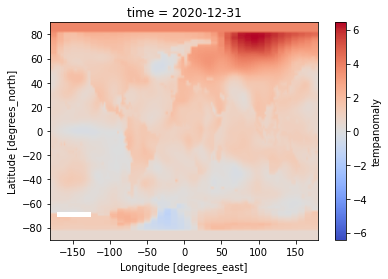

In [6]:
regrid_lat = np.arange(-90, 90, 0.125) # new coordinates
regrid_lon = np.arange(-180, 180, 0.125) # new coordinates
da_output = ds1.interp(lon=regrid_lon,
                    lat=regrid_lat,
                    method="linear",
                    kwargs={"fill_value": "extrapolate"},
                      ) # specify calculation

da_output['tempanomaly'].sel(time='2020-12-31T00:00:00.000000000').plot(cmap = 'coolwarm')
da_output

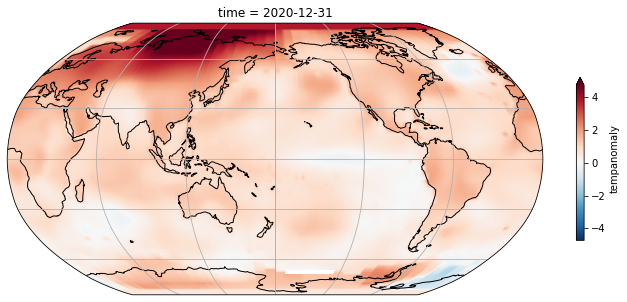

In [7]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
da_output['tempanomaly'].sel(time='2020-12-31T00:00:00.000000000').plot(
    robust=True, ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5}
)
ax.set_global()

In [10]:
da_output.to_netcdf(path + 'output.nc')

In [23]:
ds.dims

Frozen({'lat': 90, 'lon': 180, 'time': 1702, 'nv': 2})